In [47]:
import pandas as pd
import sqlite3
import numpy as np
from plotnine import *

# Connect to Database and Extract Dataset

In [48]:
conn = sqlite3.connect("sabs_moonshot.db")
data = pd.read_sql_query("""
SELECT smiles, fingerprint, r_avg_IC50, f_avg_IC50
FROM assays
INNER JOIN compounds ON compounds.id = assays.compound_id
WHERE assays.r_avg_IC50 != "" AND assays.f_avg_IC50 != "";
""", conn)
pd.to_numeric(data["r_avg_IC50"], errors='coerce')
pd.to_numeric(data["f_avg_IC50"], errors='coerce')
data["r_avg_IC50"] = data["r_avg_IC50"].replace("", np.NaN)
data["f_avg_IC50"] = data["f_avg_IC50"].replace("", np.NaN)
conn.close()
data = data[data["f_avg_IC50"] < 99]
data = data[data["r_avg_IC50"] < 99]
data

,smiles,fingerprint,r_avg_IC50,f_avg_IC50
0,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,0000000000000000000000000000000000000000010000...,14.641091,26.680129
1,O=C(Cc1cncc2ccccc12)Nc1ccccc1,0000000000000000000000000000000000000000010000...,45.077469,57.469670
2,Cc1c(N)cncc1NC(=O)Cc1cccc(Cl)c1,0000000000000000000000000000000000000000010000...,8.201698,4.222340
3,Cc1ccncc1NC(=O)Cc1cccc(Cl)c1,0000000000000000000000000000000000000000010000...,13.895165,24.566619
4,Cc1ccncc1NC(=O)Nc1cccc(Cl)c1,0000000000000000000000000000000000000000000000...,45.689263,64.413611
...,...,...,...,...
656,Cc1ccc(C)c(S(=O)(=O)N2CCN(C(=O)CCl)CC2)c1,0000000000000000000000000000000000000000000000...,1.623369,14.216485
657,O=C(Nc1cncc2ccccc12)C1CCOc2cc(Cl)c(Cl)cc21,0000000000000000000000000000000000000000000000...,0.309337,0.205428
658,O=C(CCl)N1CCN(Cc2cccc(Cl)c2)CC1,0000000000000000000000000000000000000000000000...,0.545448,2.536267
659,O=C(CCl)N1CCN(S(=O)(=O)c2cccc(F)c2)CC1,0000000000000000000000000000000000000000000000...,2.023561,3.666429


## Create X, Y Inputs and Outputs numpy arrays

In [49]:
X = np.array([[int(c) for c in data["fingerprint"].iloc[i]] for i in range(len(data["fingerprint"]))])
Y = -np.log10(np.mean(data[["r_avg_IC50", "f_avg_IC50"]], axis=1).to_numpy())

# Perform Feature Selection

### Remove Low Variance Features

In [50]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold = 0.8 * (1-0.8)) # Remove features which are same in >80% of data
X = sel.fit_transform(X)
X.shape

(424, 42)

### Remove Highly Correlated Features

In [51]:
X = pd.DataFrame(X)
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X.drop(to_drop, axis=1, inplace=True)
X = X.to_numpy()
X.shape


(424, 40)

### Final Datasets X and Y

In [52]:
X, Y # X is features, Y is avg IC50
np.save("random_forest_data/X", X)
np.save("random_forest_data/Y", Y)

(array([[1, 0, 1, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 1],
        ...,
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 1, 0]]),
 array([-1.31514314e+00, -1.70989355e+00, -7.93232769e-01, -1.28399943e+00,
        -1.74076866e+00, -1.29167216e+00, -1.38279685e+00, -1.72089212e+00,
        -1.70007183e+00, -5.02224170e-01, -6.12673150e-01, -8.41075825e-01,
        -1.04972040e+00, -1.15938083e+00,  1.87514177e-01, -1.49579898e-01,
        -1.01376260e+00, -1.16127742e-01, -8.34874212e-02, -3.81107377e-01,
        -1.37134984e+00, -1.38825297e+00,  3.04795272e-01, -3.85282583e-01,
        -4.60038949e-01, -3.39043564e-01, -3.85282583e-01, -1.04949694e+00,
        -3.77669084e-01, -1.22857681e+00, -9.82690350e-01, -1.59430776e+00,
        -7.27831304e-02, -3.85282583e-01, -6.69634671e-01, -1.20744586e+00,
        -1.40466058e+00, -7.21072325e-02, -1.21785542e+00, -1.41513607e+00,
        -8.98721188e-01, -2

/usr/local/anaconda3.7/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 11'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


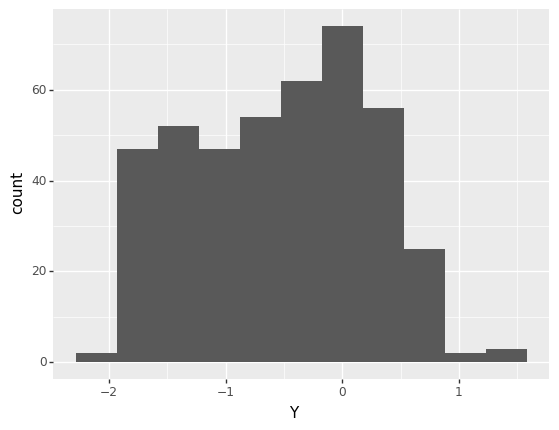

<ggplot: (8732470895185)>

In [53]:
(
    ggplot(pd.DataFrame(X, Y)) +
    geom_histogram(aes(x='Y'))
)